In [ ]:
import hashlib
import os
import requests
import six
import shutil
import tarfile
import zipfile

import numpy as np
from glob import glob
from matplotlib.pyplot import imread
from tqdm import tqdm


def read_image(filename, normalize=True, grayscale=False):
    if (grayscale):
        # one channel
        img = imread(filename, mode='L')
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    else:
        img = imread(filename)
    if normalize:
        img = img / 255.

    return img


def read_images_from_dir(dirname, **kwargs):
    img_names = os.listdir(dirname)
    imgs = [None] * len(img_names)
    for i, fname in enumerate(img_names):
        path_to_img = os.path.join(dirname, fname)
        try:
            imgs[i] = read_image(path_to_img, **kwargs)
        except:
            print("""[WARNING] 
                  Something's wrong with the file, 
                  it will be skipped""") 
    imgs = np.asarray(imgs)
    return imgs
  
  
def create_dataset_from_dir(dirname, shuffle=False, **kwargs):
    x = []
    y = []

    labels = os.listdir(dirname)                # labels are also directories

    for i, l in enumerate(labels):
        full_path = os.path.join(dirname, l)
        imgs = read_images_from_dir(full_path, **kwargs)
        x.extend(imgs)                          # add images to list
        y += [i] * len(imgs)                    # add labels to list

    x = np.asarray(x)
    y = np.asarray(y)

    if shuffle:
        idx = np.random.permutation(range(len(x)))
        x = x[idx]
        y = y[idx]

    dataset = {'data'         :  x, 
               'target'       :  y,
               'target_names' :  labels}

    return dataset


def _remove_path_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)


def _extract_archive(file_path, path='.', archive_format='auto'):
    """Extracts an archive if it matches tar, tar.gz, tar.bz, or zip formats.
    # Arguments
        file_path: path to the archive file
        path: path to extract the archive file
        archive_format: Archive format to try for extracting the file.
            Options are 'auto', 'tar', 'zip', and None.
            'tar' includes tar, tar.gz, and tar.bz files.
            The default 'auto' is ['tar', 'zip'].
            None or an empty list will return no matches found.
    # Returns
        True if a match was found and an archive extraction was completed,
        False otherwise.
    """
    if archive_format is None:
        return False
    if archive_format is 'auto':
        archive_format = ['tar', 'zip']
    if isinstance(archive_format, six.string_types):
        archive_format = [archive_format]

    for archive_type in archive_format:
        if archive_type is 'tar':
            open_fn = tarfile.open
            is_match_fn = tarfile.is_tarfile
        if archive_type is 'zip':
            open_fn = zipfile.ZipFile
            is_match_fn = zipfile.is_zipfile

        if is_match_fn(file_path):
            with open_fn(file_path) as archive:
                try:
                    archive.extractall(path)
                except (tarfile.TarError, RuntimeError,
                        KeyboardInterrupt):
                    _remove_path_if_exists(path)
                    raise
            return True
    return False


def get_file(fname,
             origin,
             md5_hash=None,
             file_hash=None,
             cache_subdir='datasets',
             hash_algorithm='auto',
             extract=False,
             archive_format='auto',
             cache_dir=None):
    """Downloads a file from a URL if it not already in the cache.
    By default the file at the url `origin` is downloaded to the
    cache_dir `~/.pdd`, placed in the cache_subdir `datasets`,
    and given the filename `fname`. The final location of a file
    `example.txt` would therefore be `~/.pdd/datasets/example.txt`.
    Files in tar, tar.gz, tar.bz, and zip formats can also be extracted.
    Passing a hash will verify the file after download. The command line
    programs `shasum` and `sha256sum` can compute the hash.
    # Arguments
        fname: Name of the file. If an absolute path `/path/to/file.txt` is
            specified the file will be saved at that location.
        origin: Original URL of the file.
        md5_hash: Deprecated in favor of 'file_hash'.
            md5 hash of the file for verification
        file_hash: The expected hash string of the file after download.
            The sha256 and md5 hash algorithms are both supported.
        cache_subdir: Subdirectory under the Keras cache dir where the file is
            saved. If an absolute path `/path/to/folder` is
            specified the file will be saved at that location.
        hash_algorithm: Select the hash algorithm to verify the file.
            options are 'md5', 'sha256', and 'auto'.
            The default 'auto' detects the hash algorithm in use.
        extract: True tries extracting the file as an Archive, like tar or zip.
        archive_format: Archive format to try for extracting the file.
            Options are 'auto', 'tar', 'zip', and None.
            'tar' includes tar, tar.gz, and tar.bz files.
            The default 'auto' is ['tar', 'zip'].
            None or an empty list will return no matches found.
        cache_dir: Location to store cached files, when None it
            defaults to the PDD directory.
    # Returns
        Path to the downloaded file
    """
    if cache_dir is None:
        cache_dir = os.path.join(os.path.expanduser('~'), '.pdd')
    if md5_hash is not None and file_hash is None:
        file_hash = md5_hash
        hash_algorithm = 'md5'
    datadir_base = os.path.expanduser(cache_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.pdd')
    datadir = os.path.join(datadir_base, cache_subdir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    fpath = os.path.join(datadir, fname)

    download = False
    if os.path.exists(fpath):
        # File found; verify integrity if a hash was provided.
        if file_hash is not None:
            if not validate_file(fpath, file_hash, algorithm=hash_algorithm):
                print('A local file was found, but it seems to be '
                      'incomplete or outdated because the ' + hash_algorithm +
                      ' file hash does not match the original value of ' +
                      file_hash + ' so we will re-download the data.')
                download = True
    else:
        download = True

    if download:
        print('Downloading data from', origin)
        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                r = requests.get(origin, 
                                 stream=True, 
                                 headers={'Accept-Encoding': None})
                file_total_size = int(r.headers['Content-Length'])
                # downloading by chunks
                if r.status_code == 200:
                    with open(fpath, "wb") as f:
                        for chunk in tqdm(r.iter_content(1024), 
                                          total=file_total_size // 1024, 
                                          ncols=57):
                            f.write(chunk)
            except requests.exceptions.HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
            except requests.exceptions.HTTPConnectionPool as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
            except requests.exceptions.URLRequired as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
        except (Exception, KeyboardInterrupt):
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if extract:
        datadir_path = os.path.splitext(fpath)[0]
        _remove_path_if_exists(datadir_path)
        _extract_archive(fpath, datadir_path)
        return datadir_path

    return fpath


def _hash_file(fpath, algorithm='sha256', chunk_size=65535):
    """Calculates a file sha256 or md5 hash.
    # Example
    ```python
        >>> from keras.data_utils import _hash_file
        >>> _hash_file('/path/to/file.zip')
        'e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855'
    ```
    # Arguments
        fpath: path to the file being validated
        algorithm: hash algorithm, one of 'auto', 'sha256', or 'md5'.
            The default 'auto' detects the hash algorithm in use.
        chunk_size: Bytes to read at a time, important for large files.
    # Returns
        The file hash
    """
    if (algorithm is 'sha256') or (algorithm is 'auto' and len(hash) is 64):
        hasher = hashlib.sha256()
    else:
        hasher = hashlib.md5()

    with open(fpath, 'rb') as fpath_file:
        for chunk in iter(lambda: fpath_file.read(chunk_size), b''):
            hasher.update(chunk)

    return hasher.hexdigest()


def validate_file(fpath, file_hash, algorithm='auto', chunk_size=65535):
    """Validates a file against a sha256 or md5 hash.
    # Arguments
        fpath: path to the file being validated
        file_hash:  The expected hash string of the file.
            The sha256 and md5 hash algorithms are both supported.
        algorithm: Hash algorithm, one of 'auto', 'sha256', or 'md5'.
            The default 'auto' detects the hash algorithm in use.
        chunk_size: Bytes to read at a time, important for large files.
    # Returns
        Whether the file is valid
    """
    if ((algorithm is 'sha256') or
            (algorithm is 'auto' and len(file_hash) is 64)):
        hasher = 'sha256'
    else:
        hasher = 'md5'

    if str(_hash_file(fpath, hasher, chunk_size)) == str(file_hash):
        return True
    else:
        return False


def _makedir_and_copy2(path, dirname, fnames):
    path_for_saving_files = os.path.join(path, dirname)
    os.makedirs(path_for_saving_files)

    for fname in fnames:
        shutil.copy2(fname, path_for_saving_files)


def datadir_train_test_split(origin_path, test_size, random_state=0):
    """Splits the data in directory on train and test.
    # Arguments
        origin_path: path to the original directory
        test_size: the size of test data fraction
    # Returns
        Tuple of paths: `(train_path, test_path)`.
    """
    train_path = os.path.join(origin_path, 'train')
    test_path = os.path.join(origin_path, 'validation')   
    _remove_path_if_exists(train_path)
    _remove_path_if_exists(test_path)

    try:
        subfolders = glob(os.path.join(origin_path, "*", ""))
        # if train/test split is already done
        if set(subfolders) == set(['train', 'validation']):
            return (train_path, test_path)
        # if train/test split is required
        # recreate train/test folders
        os.makedirs(train_path)
        os.makedirs(test_path)

        for folder in tqdm(subfolders, total=len(subfolders), ncols=57):
            # collect all images
            img_fnames = []
            for ext in ["*.jpg", "*.png", "*jpeg"]:
                img_fnames.extend(
                    glob(os.path.join(origin_path, folder, ext)))
            # set random state parameter
            rs = np.random.RandomState(random_state)
            # shuffle array
            rs.shuffle(img_fnames)
            # split on train and test
            n_test_files = int(len(img_fnames)*test_size)
            test_img_fnames = img_fnames[:n_test_files]
            train_img_fnames = img_fnames[n_test_files:]
            # copy train files into `train_path/folder`
            folder_name = os.path.basename(os.path.dirname(folder))
            _makedir_and_copy2(train_path, folder_name, train_img_fnames)
            # copy test files into `test_path/folder`
            _makedir_and_copy2(test_path, folder_name, test_img_fnames)

        for folder in subfolders:
            shutil.rmtree(folder)

    except:
        _remove_path_if_exists(train_path)
        _remove_path_if_exists(test_path)
        raise 

    return (train_path, test_path)

In [ ]:
def load_data(path='all_crops.tar', 
              split_on_train_test=False, 
              test_size=None, 
              random_state=0):
    """Loads the PDD dataset with all crops.
    # Arguments
        path: path where to cache the dataset locally
            (relative to ~/.pdd/datasets).
        split_on_train_test: flag, controls whether or not
            data should be splitted on train and test
        test_size: the size of test data fraction
    # Returns
        Path to the folder with data or tuple with train and test paths
    """
    path = "/content/drive/My Drive/pdd_model/augmentation"

    try:
        if split_on_train_test:
            print("Splitting on train and test...")
            test_size = 0.15 if test_size is None else test_size
            train_path, test_path = datadir_train_test_split(
                path, test_size, random_state)
            return (train_path, test_path)
    except:
        print("Unexpected error:", sys.exc_info()[0])
    
    return path

In [ ]:
train_data_path, test_data_path = load_data(split_on_train_test=True, random_state=13)

  0%|                             | 0/20 [00:00<?, ?it/s]

Splitting on train and test...


 10%|█▊                | 2/20 [08:48<1:19:26, 264.82s/it]

NameError: ignored

In [ ]:
train_data_path

'/content/augmentation/train'

In [ ]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/Kaliostrogoblin/PDD.git

Cloning into 'PDD'...
remote: Enumerating objects: 275, done.
remote: Total 275 (delta 0), reused 0 (delta 0), pack-reused 275
Receiving objects: 100% (275/275), 53.91 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:

import os
os.chdir('PDD')
# verify if we are in correct directory
os.listdir()

['.gitignore', 'examples', 'README.md', '.git', 'server', 'pdd']

In [ ]:
from pdd.datasets.allcrops import load_data

train_data_path, test_data_path = load_data(split_on_train_test=True, random_state=13)


100%|████████████| 45027/45027 [00:05<00:00, 8096.23it/s]

100%|███████████████████| 20/20 [00:00<00:00, 117.79it/s]

Splitting on train and test...


In [ ]:
from pdd.models import get_feature_extractor
from pdd.models import make_siamese
import tensorflow.keras.backend as K
import tensorflow as tf

# set the single session for tensorflow and keras both
sess = tf.Session()
K.set_session(sess)

In [ ]:
input_shape = (256, 256, 3)

print("Building feature extractor...")
feature_extractor = get_feature_extractor(input_shape)

print("Constructing siamese network...")
siams = make_siamese(feature_extractor,  dist='l1', loss='cross_entropy')
siams.summary()

Building feature extractor...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Constructing siamese network...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 1024)         14902496    input_2[0][0]                    
                                                     

In [ ]:
from pdd.utils.training import SiameseBatchGenerator

In [ ]:
train_batch_gen = SiameseBatchGenerator.from_directory(dirname="/content/drive/My Drive/pdd_model/all_crops/all_crops/train", augment=True)
test_batch_gen = SiameseBatchGenerator.from_directory(dirname="/content/drive/My Drive/pdd_model/all_crops/all_crops/validation")

def siams_generator(batch_gen, batch_size=None):
    while True:
        batch_xs, batch_ys = batch_gen.next_batch(batch_size)
        yield [batch_xs[0], batch_xs[1]], batch_ys

In [ ]:
siams.fit_generator(
    generator=siams_generator(train_batch_gen),
    steps_per_epoch=100,
    epochs=50,
    verbose=1,
    validation_data=siams_generator(test_batch_gen),
    validation_steps=30
)


Epoch 1/50
100/100 [==============================] - 707s 7s/step - loss: 0.6935 - acc: 0.5813 - val_loss: 0.6869 - val_acc: 0.5667
Epoch 2/50
100/100 [==============================] - 139s 1s/step - loss: 0.6990 - acc: 0.5831 - val_loss: 0.6998 - val_acc: 0.5667
Epoch 3/50
100/100 [==============================] - 146s 1s/step - loss: 0.6947 - acc: 0.5863 - val_loss: 0.6614 - val_acc: 0.6031
Epoch 4/50
 64/100 [==================>...........] - ETA: 46s - loss: 0.6953 - acc: 0.6069

In [ ]:
print("Saving feature extractor...")
feature_extractor.save('pdd_feature_extractor.h5')

Saving feature extractor...


In [ ]:
K.clear_session()
tf.reset_default_graph()
del sess

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%ls

 examples/   pdd/  '   pdd_feature_extractor.h5'   README.md   server/


In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

from pdd.models import TfKNN
from pdd.utils.data_utils import create_dataset_from_dir

In [ ]:
import tensorflow as tf
sess = tf.Session()

from tensorflow.keras import backend as K
K.set_session(sess)

print("Loading feature extractor...")
feature_extractor = load_model("pdd_feature_extractor.h5")

Loading feature extractor...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


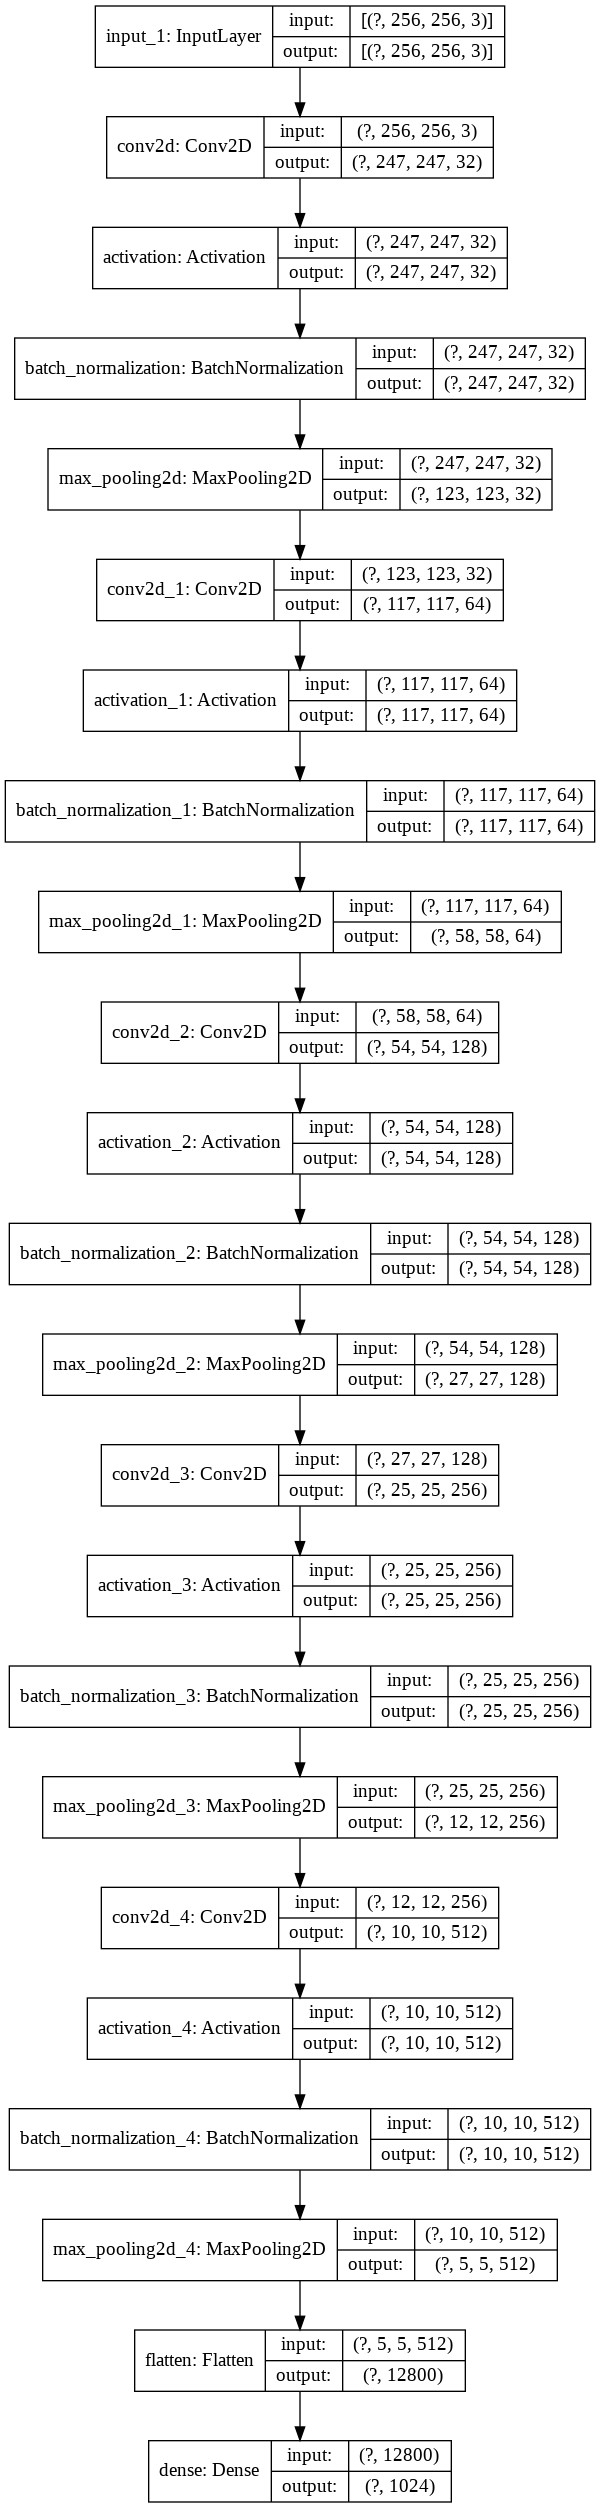

In [ ]:
from tensorflow import keras
keras.utils.plot_model(feature_extractor, show_shapes=True)

In [ ]:
feature_extractor.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 247, 247, 32)      9632      
_________________________________________________________________
activation (Activation)      (None, 247, 247, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 247, 247, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 64)      100416    
_________________________________________________________________
activation_1 (Activation)    (None, 117, 117, 64)      0     

In [ ]:
print("Loading datasets...")
train_dataset = create_dataset_from_dir(train_data_path, shuffle=True)
test_dataset = create_dataset_from_dir(test_data_path, shuffle=True)

Loading datasets...


In [ ]:
support_set_x = feature_extractor.predict(train_dataset['data'])

In [ ]:
support_set_x

array([[9.9999911e-01, 5.8265799e-01, 9.8168850e-05, ..., 6.9469213e-05,
        2.1147111e-01, 9.9963939e-01],
       [5.3117007e-01, 9.9991006e-01, 4.5149127e-01, ..., 8.4345073e-02,
        8.8738650e-02, 9.9999928e-01],
       [1.0000000e+00, 9.9130690e-01, 9.8371613e-01, ..., 3.3306479e-03,
        9.9852580e-01, 9.9998730e-01],
       ...,
       [1.0000000e+00, 1.6872585e-02, 1.4498591e-02, ..., 6.7027462e-01,
        9.9997377e-01, 9.9212050e-01],
       [1.0000000e+00, 3.3107698e-03, 7.9080760e-03, ..., 4.8875809e-06,
        1.0000000e+00, 1.0000000e+00],
       [9.9999958e-01, 9.9910325e-01, 1.2001097e-03, ..., 1.0782921e-01,
        9.9325222e-01, 9.7612083e-01]], dtype=float32)

In [ ]:
# from ..utils.timing import timeit
# from ..utils.graph_utils import freeze_session
# from ..utils.graph_utils import load_frozen_graph

import tensorflow.keras.backend as K
import tensorflow as tf
import os

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
def load_frozen_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

In [ ]:
print("Freezing feature extractor graph...")
o_names = [out.op.name for out in feature_extractor.outputs]
graph = freeze_session(sess, output_names=o_names)
tmp_fname = 'feature_extractor.pb'
tf.train.write_graph(graph, "", tmp_fname, as_text=False)
tf.reset_default_graph()
graph = load_frozen_graph(tmp_fname)
os.remove(tmp_fname)

Freezing feature extractor graph...
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 32 variables.
INFO:tensorflow:Converted 32 variables to const ops.


In [ ]:

def get_keys_from_support_set(self, x):
  print("Getting keys from support set...")
  support_set_x = feature_extractor.predict(x)

def freeze_feature_extractor_graph(self, sess):
  print("Freezing feature extractor graph...")
  o_names = [out.op.name for out in feature_extractor.outputs]
  graph = freeze_session(sess, output_names=o_names)
       
  tmp_fname = 'feature_extractor.pb'
  tf.train.write_graph(self.graph, "", tmp_fname, as_text=False)

  tf.reset_default_graph()
  self.graph = load_frozen_graph(tmp_fname)
  os.remove(tmp_fname)

In [ ]:
def prepare_support_set(self, labels):
  keys = tf.constant(support_set_x, dtype=tf.float32, 
  name="support_set_x")
  support_set_y = tf.constant(labels, 
            dtype=tf.int32, name="support_set_y")

In [ ]:
inputs = graph.get_tensor_by_name('prefix/input_1:0')

In [ ]:
inputs_rescaled = graph.get_tensor_by_name('prefix/dense/Sigmoid:0')

In [ ]:
inputs_rescaled

<tf.Tensor 'prefix/dense/Sigmoid:0' shape=(?, 1024) dtype=float32>

In [ ]:
labels = train_dataset['target']

In [ ]:
with graph.as_default():
  # prepare_support_set(labels)
  keys = tf.constant(support_set_x, dtype=tf.float32, 
  name="support_set_x")
  support_set_y = tf.constant(labels, 
            dtype=tf.int32, name="support_set_y")
  n_neighbours = tf.placeholder(tf.int32, name="KNN_n_neighbours")
  normalized_keys = tf.nn.l2_normalize(keys, axis=1)
  normalized_queries = tf.nn.l2_normalize(inputs_rescaled, axis=1)
  query_result = tf.matmul(a=normalized_keys, 
                b=tf.transpose(normalized_queries), 
                name="distance_matrix")
  preds_sims, preds_idx = tf.nn.top_k(
                tf.transpose(query_result), 
                k=n_neighbours, 
                name="predicted_nearest_idx"
            )
  preds_labels = tf.gather(support_set_y, preds_idx,
                name="predicted_classes")


In [ ]:
with tf.Session(graph=graph) as sess:
  pred = sess.run([preds_labels, preds_sims], 
                            feed_dict={
                                inputs : test_dataset['data'], 
                                n_neighbours : 1
                            })

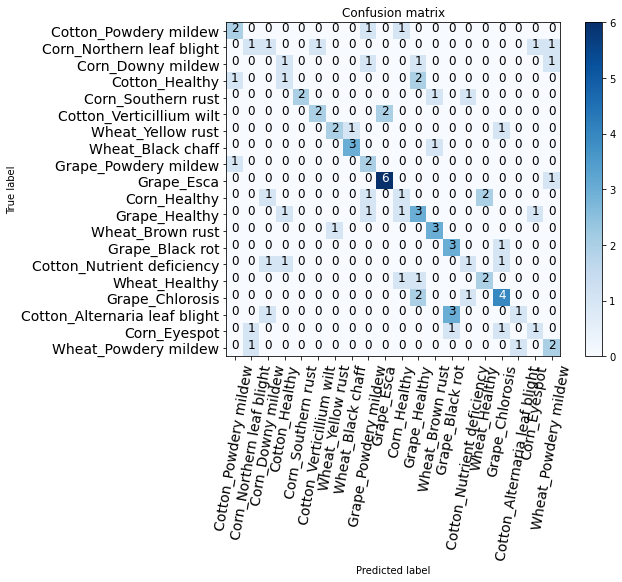

In [ ]:

from pdd.utils.metrics_vis import plot_incorrect_predictions
from pdd.utils.metrics_vis import plot_confusion_matrix
from pdd.utils.metrics_vis import plot_embeddings



pred = pred[0][:, 0]
plot_confusion_matrix(y_true=test_dataset['target'], 
                      y_pred=pred,
                      target_names=test_dataset['target_names'],
                      savefig=True)

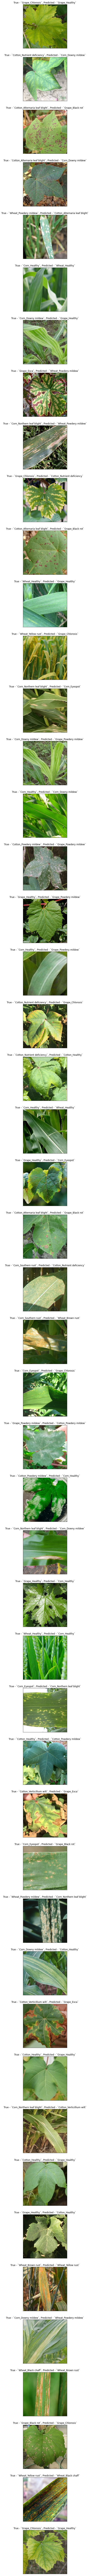

In [ ]:

plot_incorrect_predictions(imgs=test_dataset['data'], 
                           y_true=test_dataset['target'],
                           y_pred=pred,
                           target_names=test_dataset['target_names'],
                           savefig=True)

In [ ]:
accuracy = accuracy_score(test_dataset['target'], pred)
print("Accuracy: %.2f" % accuracy)

Accuracy: 0.46


Demo (optional)

In [ ]:
# from ..utils.timing import timeit
# from ..utils.graph_utils import freeze_session
# from ..utils.graph_utils import load_frozen_graph

import tensorflow.keras.backend as K
import tensorflow as tf
import os


class TfKNN_1:
    def __init__(self, sess, feature_extractor, support_set):
        self.feature_extractor = feature_extractor
        self._get_keys_from_support_set(support_set[0])
        # after getting features we can freeze graph 
        self._freeze_feature_extractor_graph(sess)
        self.make_fknn_graph(support_set[1])


    # @timeit
    def _get_keys_from_support_set(self, x):
        print("Getting keys from support set...")
        self.support_set_x = self.feature_extractor.predict(x)


    # @timeit
    def _freeze_feature_extractor_graph(self, sess):
        print("Freezing feature extractor graph...")
        o_names = [out.op.name for out in self.feature_extractor.outputs]
        self.graph = freeze_session(sess, output_names=o_names)
       
        tmp_fname = 'feature_extractor.pb'
        tf.train.write_graph(self.graph, "", tmp_fname, as_text=False)

        tf.reset_default_graph()
        self.graph = load_frozen_graph(tmp_fname)
        os.remove(tmp_fname)


    def _prepare_support_set(self, labels):
        # rescale support_set, extracting features
        self.keys = tf.constant(self.support_set_x, dtype=tf.float32, 
            name="support_set_x")
        self.support_set_y = tf.constant(labels, 
            dtype=tf.int32, name="support_set_y")


    # @timeit
    def make_fknn_graph(self, labels):
        '''fast KNN graph
    
        # Arguments
            labels : training labels
        '''
        print("Creating TfKNN graph...")
        tensors_per_node = [node.values() for node in self.graph.get_operations()] 
        tensor_names = [tensor.name for tensors in tensors_per_node for tensor in tensors] 
        print(tensor_names)
        self.inputs = self.graph.get_tensor_by_name('prefix/input_1:0')
        # rescale to embeddings space
        self.inputs_rescaled = self.graph.get_tensor_by_name('prefix/dense/Sigmoid:0')
        
        with self.graph.as_default():
            self._prepare_support_set(labels)
            # init placeholder for the number of neighbours
            self.n_neighbours = tf.placeholder(tf.int32, name="KNN_n_neighbours")
            # input placeholder for test images
            # self.norm_inputs = tf.cond(
            #     tf.reduce_max(self.inputs) > 1, 
            #     lambda: self.inputs / 255., # if True, normalize
            #     lambda: self.inputs) # else use the original ones
            # normalized keys and query
            self.normalized_keys = tf.nn.l2_normalize(self.keys, axis=1)
            self.normalized_queries = tf.nn.l2_normalize(self.inputs_rescaled, axis=1)
            # result of the query (cosine distances)
            self.query_result = tf.matmul(
                a=self.normalized_keys, 
                b=tf.transpose(self.normalized_queries), 
                name="distance_matrix")
            # predict similarities and indices for n_neighbours
            self.preds_sims, self.preds_idx = tf.nn.top_k(
                tf.transpose(self.query_result), 
                k=self.n_neighbours, 
                name="predicted_nearest_idx"
            )
            # predicted classes
            self.preds_labels = tf.gather(self.support_set_y, self.preds_idx,
                name="predicted_classes")

    # @timeit
    def predict(self, imgs, n_neighbours=1):
        print("Making prediction for %d images..." % len(imgs))
        with tf.Session(graph=self.graph) as sess:
            return sess.run([self.preds_labels, self.preds_sims], 
                            feed_dict={
                                self.inputs : imgs, 
                                self.n_neighbours : n_neighbours
                            })


    # @timeit
    def save_graph_for_serving(self, export_dir):
        print("Saving graph for serving...")
        with tf.Session(graph=self.graph) as sess:
            tf.saved_model.simple_save(
                session=sess,
                inputs={
                    "inputs" : self.inputs,
                    "n_neighbours" : self.n_neighbours}, 
                export_dir=export_dir,
                outputs={
                    "predicted_labels" : self.preds_labels,
                    "predicted_similarities" : self.preds_sims})

In [ ]:
support_set_x = feature_extractor.predict(train_dataset['data']
                                      )

InvalidArgumentError: ignored

In [ ]:

tfknn = TfKNN_1(sess, 
              feature_extractor, 
              (train_dataset['data'], train_dataset['target']))

Getting keys from support set...


InvalidArgumentError: ignored

In [ ]:
 tensors_per_node = [node.values() for node in graph.get_operations()] 
 tensor_names = [tensor.name for tensors in tensors_per_node for tensor in tensors] 

In [ ]:
tensors_per_node

[(<tf.Tensor 'prefix/input_1:0' shape=(?, 256, 256, 3) dtype=float32>,),
 (<tf.Tensor 'prefix/conv2d/kernel:0' shape=(10, 10, 3, 32) dtype=float32>,),
 (<tf.Tensor 'prefix/conv2d/bias:0' shape=(32,) dtype=float32>,),
 (<tf.Tensor 'prefix/conv2d/Conv2D/ReadVariableOp:0' shape=(10, 10, 3, 32) dtype=float32>,),
 (<tf.Tensor 'prefix/conv2d/Conv2D:0' shape=(?, 247, 247, 32) dtype=float32>,),
 (<tf.Tensor 'prefix/conv2d/BiasAdd/ReadVariableOp:0' shape=(32,) dtype=float32>,),
 (<tf.Tensor 'prefix/conv2d/BiasAdd:0' shape=(?, 247, 247, 32) dtype=float32>,),
 (<tf.Tensor 'prefix/activation/Relu:0' shape=(?, 247, 247, 32) dtype=float32>,),
 (<tf.Tensor 'prefix/batch_normalization/gamma:0' shape=(32,) dtype=float32>,),
 (<tf.Tensor 'prefix/batch_normalization/beta:0' shape=(32,) dtype=float32>,),
 (<tf.Tensor 'prefix/batch_normalization/moving_mean:0' shape=(32,) dtype=float32>,),
 (<tf.Tensor 'prefix/batch_normalization/moving_variance:0' shape=(32,) dtype=float32>,),
 (<tf.Tensor 'prefix/keras_l